# CHECK FOR CUDA COMPATIBILITY

    Install dependencies
    and check working directory

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
torch.cuda.device_count()

1

In [3]:
torch.cuda.get_device_name(0)


'NVIDIA T1200 Laptop GPU'

In [11]:
!pip install -q -U transformers
!pip install -q -U accelerate

In [12]:
import pandas as pd
import matplotlib

import os
os.getcwd()



'/home/jg/Documents/bert_models'

# Load data into dataframe
Make sure the path to jsonl data is correct

In [15]:
df= pd.read_json('./multi_label_class_train.jsonl', lines=True)

df

,name,categories
0,Irresistibles Cheese Fondue With Swiss Cheeses,"[Dairy & Eggs, Packaged Cheese, Fondue]"
1,Fromalp Authentic Swiss Fondue Cheese,"[Dairy & Eggs, Packaged Cheese, Fondue]"
2,Fromalp Gourmet Swiss Fondue Cheese,"[Dairy & Eggs, Packaged Cheese, Fondue]"
3,Monsieur Gustav Lactose-Free Raclette Cheese Trio,"[Dairy & Eggs, Packaged Cheese, Fondue]"
4,Philadelphia Whipped Cream Cheese Frosting Spread,"[Dairy & Eggs, Packaged Cheese, Cream Cheese &..."
...,...,...
5955,Schneiders Hickory Smoked Classic Cut Bacon,"[Meat & Poultry, Sausages & Bacon, Bacon]"
5956,Selection Fully Cooked Smoked Bacon,"[Meat & Poultry, Sausages & Bacon, Bacon]"
5957,Maple Leaf Naturally Smoked Bacon,"[Meat & Poultry, Sausages & Bacon, Bacon]"
5958,Olymel Naturally Smoked Bacon,"[Meat & Poultry, Sausages & Bacon, Bacon]"


<Axes: ylabel='Frequency'>

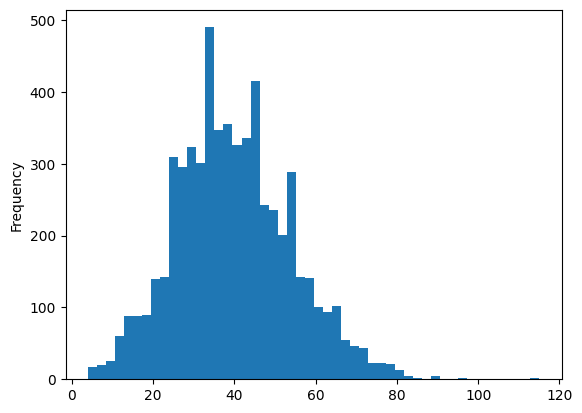

In [16]:
df['name'].str.len().plot.hist(bins=50)

In [17]:
cat_counts= [category for row in df['categories'] for category in row]

pd.Series(cat_counts).value_counts()

Health & Beauty               1465
Frozen                        1269
Household & Cleaning           940
Deli & Prepared Meals          663
Fruits & Vegetables            533
                              ... 
Breasts & Magret                 1
Marinated Cuts                   1
Spreads, Mousse & Caviar         1
Single Serving Yogurts           1
Children's Bath Essentials       1
Name: count, Length: 254, dtype: int64

# Load Bert Model and Binarizer

Gets pretrained model from Huggingface and Binarizer for classification tasks
Also foramts data and turns them into tensors (a tensor is an array of numbers)

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel=MultiLabelBinarizer()
labels =multilabel.fit_transform(df['categories']).astype('float32')

labels.shape[1]

254

In [42]:
texts= df['name'].tolist()
len(texts)

5960

In [43]:
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


train_text, val_text, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=37)

In [44]:
checkpoint= 'distilbert/distilbert-base-uncased'
tokenizer= AutoTokenizer.from_pretrained(checkpoint)
model= AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels= labels.shape[1])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

# Data Format and Validation

Input ids are are the inputs turned into iteger values as a tensor, with 0 being a padding token (empty space) Special tokens include 101 and 102
which stand for [start] and [end] respectively

A validation function is used to determine if training is going well and loss is dropping consistently

In [24]:
train_dataset= CustomDataset(train_text, train_labels, tokenizer)
val_dataset= CustomDataset(val_text, val_labels, tokenizer)

train_dataset[90]

{'input_ids': tensor([ 101, 6501, 7349, 2310, 2389, 4190, 8040, 8095, 7361, 5498,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [30]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch

def multi_label_metrics (predictions, labels, threshold=0.3):
  sigmoid= torch.nn.Sigmoid()
  probs= sigmoid(torch.Tensor(predictions))

  y_pred= np.zeros(probs.shape)
  y_pred[np.where(probs>= threshold)]= 1
  y_true= labels

  f1= f1_score(y_true, y_pred, average= "macro")
  # roc_auc= roc_auc_score(y_true, y_pred, average= "macro")
  hamming= hamming_loss(y_true, y_pred)

  metrics= {
      #"roc_auc": roc_auc,
      "f1": f1,
      "hamming_loss": hamming_loss
  }

  return metrics


def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_label_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

# Training

In [34]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)


trainer.train()

Step,Training Loss
500,0.094600
1000,0.034800
1500,0.023900
2000,0.018600
2500,0.015500


TrainOutput(global_step=2980, training_loss=0.03368012041053516, metrics={'train_runtime': 480.3833, 'train_samples_per_second': 49.627, 'train_steps_per_second': 6.203, 'total_flos': 793053783736320.0, 'train_loss': 0.03368012041053516, 'epoch': 5.0})

In [35]:
trainer.evaluate()

/home/jg/Documents/bert_models/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.015658551827073097,
 'eval_f1': 0.22966147838305442,
 'eval_hamming_loss': <function sklearn.metrics._classification.hamming_loss(y_true, y_pred, *, sample_weight=None)>,
 'eval_runtime': 7.6751,
 'eval_samples_per_second': 155.308,
 'eval_steps_per_second': 19.413,
 'epoch': 5.0}

# Saving the model

Model files will be saved in the directory marked below, in this case distilbert-multi-label-gropher
the multi label binarizer will also have to be saved as a pkl file for converting the numeric values back into string values

In [36]:
trainer.save_model("distilbert-multi-label-gropher")

In [37]:
tokenizer.save_pretrained('distilbert-multi-label-gropher')

('distilbert-multi-label-gropher/tokenizer_config.json',
 'distilbert-multi-label-gropher/special_tokens_map.json',
 'distilbert-multi-label-gropher/vocab.txt',
 'distilbert-multi-label-gropher/added_tokens.json',
 'distilbert-multi-label-gropher/tokenizer.json')

# Inference

Please also see Multi_Class_load notebook for an example of inferencing

In [38]:
import pickle
with open("multi-label-binarizer.pkl", "wb") as f:
  pickle.dump(multilabel, f)

In [39]:
finetuned_model = AutoModelForSequenceClassification.from_pretrained("./distilbert-multi-label-gropher")

input= "Oikos Greek Yogurt"
encoding= tokenizer(input, return_tensors="pt")
encoding.to(finetuned_model.device)

outputs= finetuned_model(**encoding)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ -7.4573,  -8.9593,  -8.2310,  -4.7732,  -8.5629,  -9.4515,  -6.9495,
          -6.5195,  -8.2206,  -8.4605,  -7.2584,  -7.2662,  -6.4384,  -9.0567,
          -7.2663,  -8.7086,  -9.1394,  -8.1331,  -7.5014,  -8.4546,  -7.6940,
          -9.0242,  -8.4477,  -8.0880,  -8.7421,  -8.6860, -11.3160,  -8.1740,
          -7.4666,  -7.5527,  -7.4196,  -8.9741,  -7.9545, -10.3996,  -8.0009,
          -8.1727,  -9.0373,  -7.8594,  -8.7662,  -8.7662,  -9.0599,  -8.7169,
          -9.2936,  -6.1901,  -7.7008,  -8.5302,  -8.2285,  -8.1487,  -7.4840,
          -8.9847,  -9.5005,  -9.6253,  -9.6101,  -9.1085, -10.4842,   3.1233,
          -3.9193,  -7.5125,  -8.7587,  -7.0989,  -8.7123,  -8.3331,  -5.6786,
          -8.4191,  -9.7701,  -7.3980,  -8.2935,  -7.9152,  -6.7260,  -1.9221,
          -7.0341,  -8.8692,  -8.2788,  -7.9133,  -8.4350,  -8.2100,  -9.0163,
          -9.8019,  -6.7763,  -8.4753,  -8.2618,  -7.5541,  -8.4747,  -8.5716,
         

In [40]:
sigmoid= torch.nn.Sigmoid()
probs= sigmoid(outputs.logits[0].cpu())
preds= np.zeros(probs.shape)

preds[np.where(probs>=0.3)] = 1

file = open("multi-label-binarizer.pkl", 'rb')

multilabel_pkl=pickle.load(file)

multilabel_pkl.classes_

multilabel_pkl.inverse_transform(preds.reshape(1,-1))

[('Dairy & Eggs', 'Yogurt')]